In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Import Libraries

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from skimage import transform
import h5py

from keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, concatenate
from keras.layers import Input, AveragePooling2D, Reshape, Permute
from keras.layers import Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
K.set_image_data_format('channels_last')

## Utils

In [8]:
def create_dataset(data_path, start_id, end_id):
  """
  Get data and create a dataset
  """
  X = np.empty((0, 160, 120, 3))
  y = np.empty((0, 160, 120, 1))
  ids = np.arange(start_id, end_id, 1)
  for i in range(len(ids)):
    id = "000{}".format(ids[i])
    print("Obtaining images from...{}".format(id))

    # get homography transformation matrices
    H_rgb = np.array(np.load(os.path.join(data_path, id, "align_PTr_RGB.npy")))
    H_ir = np.array(np.load(os.path.join(data_path, id, "align_PTr_IR.npy")))
    H = np.matmul(np.linalg.inv(H_rgb), H_ir) # RGB -> IR tarnsformation
    tform = transform.ProjectiveTransform(matrix=H)

    path_X = os.path.join(data_path, id, "RGB", "cover1")
    for file in os.listdir(path_X):
      if file.endswith(".png"):
          # get X images
          path_im = os.path.join(path_X, file)
          im_X = io.imread(path_im)
          im_X = transform.warp(im_X, tform)
          im_X = im_X[0:160, 0:120]
          X = np.vstack((X, im_X.reshape(1, 160, 120, 3)))

          # get y images
          path_y = os.path.join(data_path, id, "IR", "cover1")
          path_im = os.path.join(path_y, file)
          im_y = io.imread(path_im)
          y = np.vstack((y, im_y.reshape(1, 160, 120, 1)))

    # save dataset
    dataset_id = "Covered1_IR_{:n}_{:n}.hdf5".format(start_id, end_id)
    dataset = h5py.File(os.path.join("/content/drive/MyDrive/vip_cup_2021/data", dataset_id), mode='w')
    dataset.create_dataset('X', data=X)
    dataset.create_dataset('y', data=y)
    dataset.close() 

def load_data(dataset_id):
    """
    load data from the sepcified dataset
    """
    save_path = '/content/drive/MyDrive/vip_cup_2021/data/{}.hdf5'.format(dataset_id)
    dataset = h5py.File(save_path, mode='r')
    X = np.array(dataset['X'])
    y = np.array(dataset['y'])
    return X, y

def plot(*argv, titles=None):
    fig, axes = plt.subplots(1, len(argv))
    ax = axes.ravel()  
    for i in range(len(argv)):
      ax[i].imshow(argv[i].squeeze())
      if titles is not None:
        ax[i].set_title(titles[i])
    fig.tight_layout()
    plt.show()

## Network

In [9]:
class JointConvSQDLSTMNet():
    """
    The joint convolutional and spatial quad-directional LSTM network proposed by
    M. V. Perera and A. De Silva, "A Joint Convolutional and Spatial Quad-Directional 
    LSTM Network for Phase Unwrapping," ICASSP 2021 - 2021 IEEE International Conference 
    on Acoustics, Speech and Signal Processing (ICASSP), 2021, pp. 4055-4059, 
    doi: 10.1109/ICASSP39728.2021.9414748.
    """
    def __init__(self, input_shape):
        super(JointConvSQDLSTMNet, self).__init__()
        self.input_shape = input_shape

    def getModel(self):
        """
        Defines the joint convoltional and spatial quad-directional LSTM network
        """
        ## input to the network
        input = Input(self.input_shape)

        ## encoder network
        c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
        c1 = BatchNormalization()(c1)
        c1 = Activation('relu')(c1)
        p1 = AveragePooling2D()(c1)

        c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
        c2 = BatchNormalization()(c2)
        c2 = Activation('relu')(c2)
        p2 = AveragePooling2D()(c2)

        c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
        c3 = BatchNormalization()(c3)
        c3 = Activation('relu')(c3)
        p3 = AveragePooling2D()(c3)

        # decoder Network
        u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(p3)
        u6 = concatenate([u6, c3])
        c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
        c6 = BatchNormalization()(c6)
        c6 = Activation('relu')(c6)

        u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c2])
        c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
        c7 = BatchNormalization()(c7)
        c7 = Activation('relu')(c7)

        u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c1])
        c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
        c8 = BatchNormalization()(c8)
        c8 = Activation('relu')(c8)

        ## output layer
        output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
        output = Activation('linear')(output)

        ## define the model
        model = Model(inputs=[input], outputs=[output])
        return model

## Create Dataset

In [210]:
## create dataset 
data_path = "/content/drive/MyDrive/vip_cup_2021/data/train"
create_dataset(data_path, 31, 41)

Obtaining images from...00031
Obtaining images from...00032
Obtaining images from...00033
Obtaining images from...00034
Obtaining images from...00035
Obtaining images from...00036
Obtaining images from...00037
Obtaining images from...00038
Obtaining images from...00039
Obtaining images from...00040


## User Inputs

In [10]:
## user inputs
use_JointConvSQDLSTMNet = True
dataset_id = "Covered1_IR_31_41"
image_size = (160, 120, 3)
lr = 1e-3
loss = "mean_squared_error"
batch_size = 8
epochs = 100

## Load Data

Number of Data Samples : 450


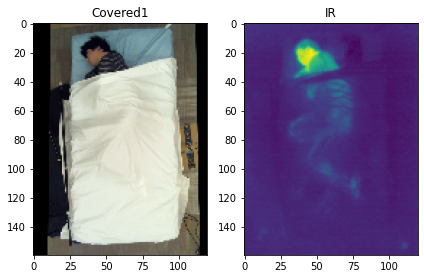

In [11]:
## load phase data and visualize a pair
X, y = load_data(dataset_id)
print("Number of Data Samples : {:n}".format(X.shape[0]))
idx = np.random.randint(0, X.shape[0])
plot(X[idx], y[idx], titles=["Covered1", "IR"])

## Train-Test Split

In [12]:
## rescale
y = y/255.0

## Split Dataset
X_test, y_test = X[-45:], y[-45:]
X, y = X[:-45], y[:-45]
print("Number of Training Samples : {:n}".format(X.shape[0]))
print("Number of Testing Samples : {:n}".format(X_test.shape[0]))

Number of Training Samples : 405
Number of Testing Samples : 45


## Define Model

In [13]:
## get model
if use_JointConvSQDLSTMNet:
    network_id = 'JointConvSQDLSTMNet'
    model = JointConvSQDLSTMNet(image_size).getModel()
    model.summary()

## define model specs
model_id = 'Model_{}_{}'.format(network_id,dataset_id)
model_path = '/content/drive/MyDrive/vip_cup_2021/models/{}.h5'.format(model_id)

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=loss
)

earlystopper = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='loss',
    verbose=1,
    save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 120, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 120, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 120, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 120, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train Model

In [14]:
## train the model
print("Number of Training Samples : {:n}".format(X.shape[0]))
history = model.fit(
    x = X,
    y = y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint, earlystopper]   
)

Number of Training Samples : 405
Epoch 1/100
51/51 [==============================] - 53s 53ms/step - loss: 0.1921

Epoch 00001: loss improved from inf to 0.07359, saving model to /content/drive/MyDrive/vip_cup_2021/models/Model_JointConvSQDLSTMNet_Covered1_IR_31_41.h5
Epoch 2/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0101

Epoch 00002: loss improved from 0.07359 to 0.00913, saving model to /content/drive/MyDrive/vip_cup_2021/models/Model_JointConvSQDLSTMNet_Covered1_IR_31_41.h5
Epoch 3/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0069

Epoch 00003: loss improved from 0.00913 to 0.00649, saving model to /content/drive/MyDrive/vip_cup_2021/models/Model_JointConvSQDLSTMNet_Covered1_IR_31_41.h5
Epoch 4/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0055

Epoch 00004: loss improved from 0.00649 to 0.00520, saving model to /content/drive/MyDrive/vip_cup_2021/models/Model_JointConvSQDLSTMNet_Covered1_IR_31_41.h5
Epoch 5/10

## Model Convergence

<function matplotlib.pyplot.show>

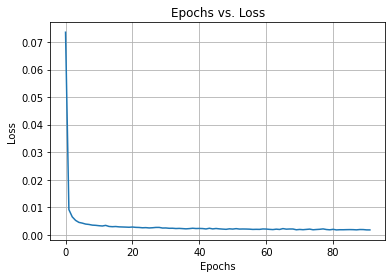

In [15]:
## plot epochs vs loss
loss = history.history['loss']
epochs = np.arange(0, len(loss), 1)
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs. Loss")
plt.grid()
plt.show

## Inference

In [16]:
## predict IR image
y_pred = model.predict(X_test, batch_size=batch_size)

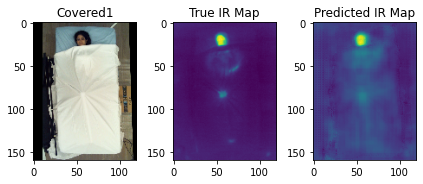

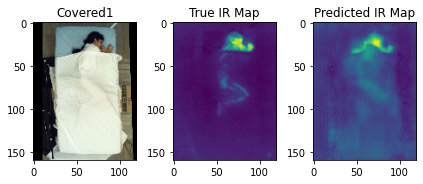

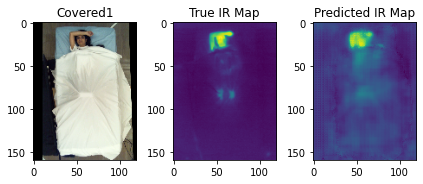

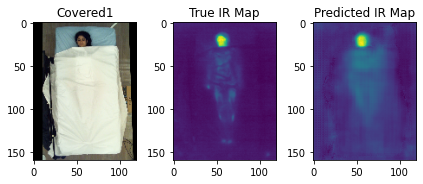

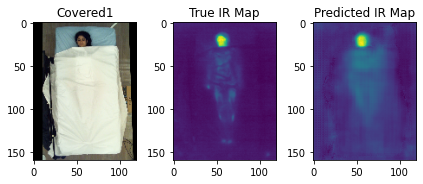

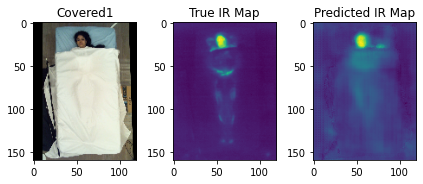

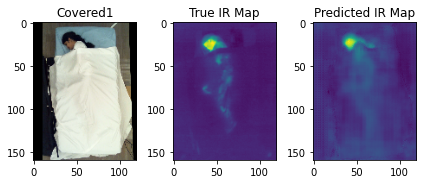

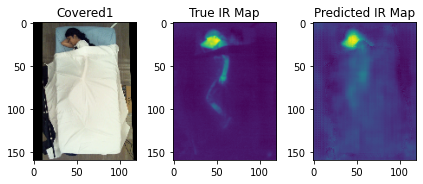

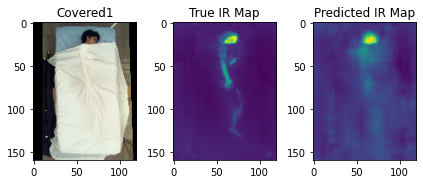

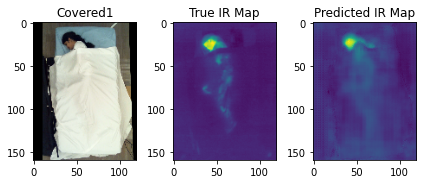

In [18]:
## Visualize some results
indices = np.random.randint(0, X_test.shape[0], size=(10, ))
for i in range(10):
  Xi = X_test[indices[i]]
  yi = y_test[indices[i]]
  ypi = y_pred[indices[i]]

  # visualize
  plot(Xi, yi, ypi, titles=["Covered1", "True IR Map", "Predicted IR Map"])